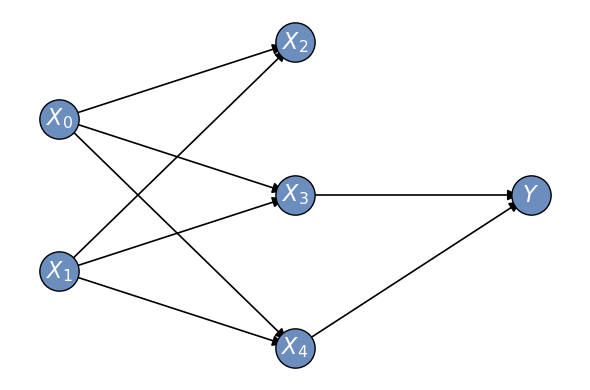

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

# Define DAG
G = nx.DiGraph()
G.add_nodes_from(["$X_0$", "$X_1$", "$X_2$", "$X_3$", "$X_4$", "$Y$"])

# Define edges
G.add_edges_from([
    ("$X_0$", "$X_2$"),  # Day of Week -> Traffic State
    ("$X_1$", "$X_2$"),  # Time of Day -> Traffic State
    ("$X_0$", "$X_3$"),  # Day of Week -> Boarding Passengers
    ("$X_1$", "$X_3$"),  # Time of Day -> Boarding Passengers
    ("$X_0$", "$X_4$"),  # Day of Week -> Alighting Passengers
    ("$X_1$", "$X_4$"),  # Time of Day -> Alighting Passengers
    ("$X_3$", "$Y$"),    # Boarding Passengers -> Dwelling Time
    ("$X_4$", "$Y$"),    # Alighting Passengers -> Dwelling Time
])

# Adjusted layout
pos = {
    "$X_0$": (-1.5, 0.8),
    "$X_1$": (-1.5, 0),
    "$X_2$": (0, 1.2),
    "$X_3$": (0, 0.4),
    "$X_4$": (0, -0.4),
    "$Y$": (1.5, 0.4),
}

# Create the plot
plt.figure(figsize=(6, 4))  # Suitable for papers
nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#6C8EBF", edgecolors="black")  # Larger nodes
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", arrowsize=16, width=1.2, edge_color="black")

# Add text inside the nodes with LaTeX formatting
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=16, font_color="white", font_weight="bold")

# Title and plot settings
plt.tight_layout()  # Automatically adjust spacing to prevent cut-offs
plt.axis("off")
plt.show()


In [2]:
np.random.seed(42)

# Define sinusoidal functions for daily and weekly patterns
def daily_pattern(time_of_day, peak_hour=8, amplitude=1.0):
    return amplitude * np.sin((time_of_day - peak_hour) * np.pi / 12)

def weekly_pattern(day_of_week, peak_day=3, amplitude=1.0):
    return amplitude * np.cos((day_of_week - peak_day) * np.pi / 3.5)

# Environment-specific parameters
bus_stop_params = {
    0: {"traffic_amplitude": 2, "traffic_peak": 8, "traffic_noise": 1.0,
        "boarding_base": 1.0, "boarding_amplitude": 0.8, "boarding_peak": 8,
        "alighting_base": 0.8, "alighting_amplitude": 0.7, "alighting_peak": 18,
        "dwell_board_coeff": 0.4, "dwell_alight_coeff": 0.3, "dwell_noise": 0.5},
    1: {"traffic_amplitude": 3, "traffic_peak": 9, "traffic_noise": 1.5,
        "boarding_base": 1.2, "boarding_amplitude": 1.0, "boarding_peak": 7,
        "alighting_base": 1.0, "alighting_amplitude": 0.6, "alighting_peak": 17,
        "dwell_board_coeff": 0.5, "dwell_alight_coeff": 0.2, "dwell_noise": 0.7}
}

# Traffic state (now only for observation, not causal to dwelling time)
def generate_traffic_state(bus_stop, day_of_week, time_of_day):
    p = bus_stop_params[bus_stop]
    return daily_pattern(time_of_day, p["traffic_peak"], p["traffic_amplitude"]) + \
           weekly_pattern(day_of_week, 3, 1.5) + \
           np.random.normal(0, p["traffic_noise"])

# Boarding passengers
def generate_boarding(bus_stop, day_of_week, time_of_day):
    p = bus_stop_params[bus_stop]
    base_rate = np.exp(p["boarding_base"] + daily_pattern(time_of_day, p["boarding_peak"], p["boarding_amplitude"]) +
                        weekly_pattern(day_of_week, 3, 0.5))
    return np.random.poisson(lam=base_rate)

# Alighting passengers
def generate_alighting(bus_stop, day_of_week, time_of_day):
    p = bus_stop_params[bus_stop]
    base_rate = np.exp(p["alighting_base"] + daily_pattern(time_of_day, p["alighting_peak"], p["alighting_amplitude"]) +
                        weekly_pattern(day_of_week, 4, 0.4))
    return np.random.poisson(lam=base_rate)

# Dwelling time with linear effects
def generate_dwell_time(bus_stop, boarding, alighting):
    p = bus_stop_params[bus_stop]
    return max(1 + p["dwell_board_coeff"] * boarding + p["dwell_alight_coeff"] * alighting +
               np.random.normal(0, p["dwell_noise"]), 0)


In [3]:
N = 500
bus_stops = np.random.choice([0, 1], N)
days = np.random.randint(0, 7, N)
times = np.random.uniform(0, 24, N)

data = []
for bus_stop, day, time in zip(bus_stops, days, times):
    traffic = generate_traffic_state(bus_stop, day, time)
    boarding = generate_boarding(bus_stop, day, time)
    alighting = generate_alighting(bus_stop, day, time)
    dwell_time = generate_dwell_time(bus_stop, boarding, alighting)

    data.append([bus_stop, day, time, traffic, boarding, alighting, dwell_time])

df_bus = pd.DataFrame(data, columns=["bus_stop", "day_of_week", "time_of_day", "traffic_state", "boarding_passengers", "alighting_passengers", "dwelling_time"])

# Standardize y (dwelling time) to improve sampling efficiency
df_bus["dwelling_time"] = (df_bus["dwelling_time"] - df_bus["dwelling_time"].mean()) / df_bus["dwelling_time"].std()


In [4]:
df_bus

,bus_stop,day_of_week,time_of_day,traffic_state,boarding_passengers,alighting_passengers,dwelling_time
0,0,6,18.455698,-0.342574,2,3,-0.552698
1,1,4,22.674378,0.963541,2,10,0.436952
2,0,4,20.391537,1.650413,5,3,0.356532
3,0,6,5.936354,-4.313852,1,2,-1.158920
4,0,0,10.813059,0.976204,3,1,-0.591214
...,...,...,...,...,...,...,...
495,0,4,19.893971,1.277518,3,4,-0.059569
496,0,5,0.888183,-3.127109,0,4,-1.385943
497,1,2,14.310477,2.826131,8,1,1.215534
498,0,4,5.520212,1.070443,2,4,0.122831


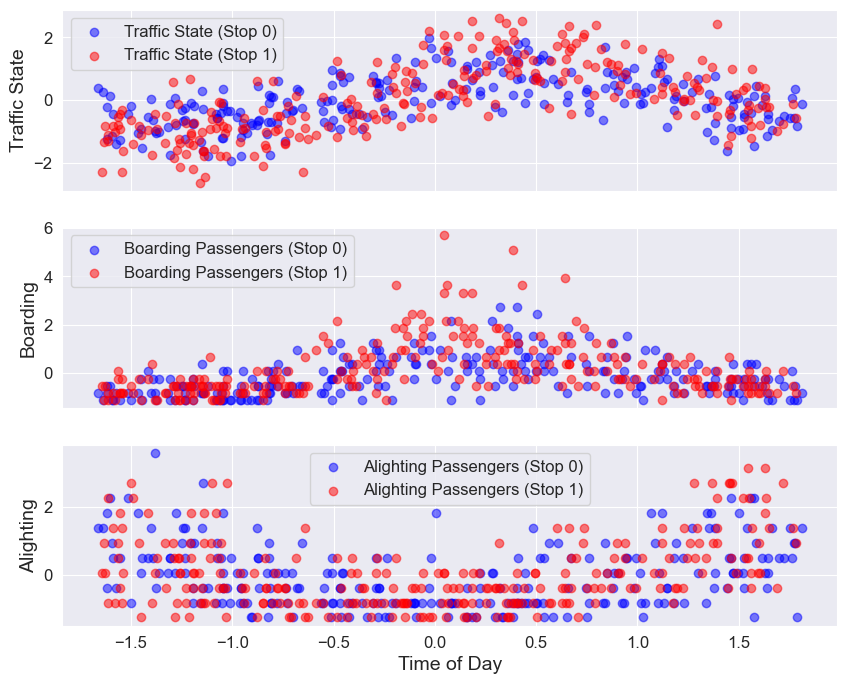

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
colors = {0: "blue", 1: "red"}

for bus_stop in [0, 1]:
    subset = df_bus[df_bus["bus_stop"] == bus_stop]
    axes[0].scatter(subset["time_of_day"], subset["traffic_state"], alpha=0.5, label=f"Traffic State (Stop {bus_stop})", color=colors[bus_stop])
    axes[1].scatter(subset["time_of_day"], subset["boarding_passengers"], alpha=0.5, label=f"Boarding Passengers (Stop {bus_stop})", color=colors[bus_stop])
    axes[2].scatter(subset["time_of_day"], subset["alighting_passengers"], alpha=0.5, label=f"Alighting Passengers (Stop {bus_stop})", color=colors[bus_stop])

axes[0].set_ylabel("Traffic State", fontsize=14)  # Larger font size for y-axis label
axes[0].legend(fontsize=12)                      # Larger font size for legend

axes[1].set_ylabel("Boarding", fontsize=14)
axes[1].legend(fontsize=12)

axes[2].set_xlabel("Time of Day", fontsize=14)   # Larger font size for x-axis label
axes[2].set_ylabel("Alighting", fontsize=14)
axes[2].legend(fontsize=12)

# Adjust tick label sizes
for ax in axes:
    ax.tick_params(axis="both", which="major", labelsize=12)

plt.show()

In [6]:
# Some cleaning:
# List the continuous columns to scale
continuous_cols = ["time_of_day", "traffic_state", "boarding_passengers", "alighting_passengers"]
scaler = StandardScaler()
df_bus[continuous_cols] = scaler.fit_transform(df_bus[continuous_cols])

# 1. Build your X matrix (predictors) and Y vector (target)
#    Let's choose these 3 main predictors for dwell_time
predictors = [
    "time_of_day",
    "day_of_week",
    "traffic_state",
    "boarding_passengers",
    "alighting_passengers",
]

X_np = df_bus[predictors].values  # shape (N, D)
Y_np = df_bus["dwelling_time"].values  # shape (N,)

In [7]:
# 2. Environment array (0 or 1), shape (N,)
env_np = df_bus["bus_stop"].values
E = df_bus["bus_stop"].nunique()  # Should be 2

N = len(df_bus)
D = X_np.shape[1]

# 3. Convert to JAX arrays
X_jax = jnp.array(X_np, dtype=jnp.float32)
Y_jax = jnp.array(Y_np, dtype=jnp.float32)
e_jax = jnp.array(env_np, dtype=jnp.int32)


# RUN THIS FOR HORSESHOE

In [8]:
kernel = NUTS(horseshoe_hierarchical_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(
    random.PRNGKey(42),
    N=N,
    D=D,
    E=E,
    e=e_jax,
    X=X_jax,
    y=Y_jax
)
posterior_samples = mcmc.get_samples()
mcmc.print_summary()


sample: 100%|██████████| 3000/3000 [00:01<00:00, 1689.03it/s, 31 steps of size 8.99e-02. acc. prob=0.89]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta[0,0]     -0.01      0.02     -0.01     -0.04      0.02   1164.89      1.00
      beta[0,1]     -0.00      0.01     -0.00     -0.01      0.00   1166.78      1.00
      beta[0,2]     -0.01      0.02     -0.00     -0.05      0.03   1058.76      1.00
      beta[0,3]      0.81      0.03      0.80      0.76      0.86   1152.47      1.00
      beta[0,4]      0.38      0.02      0.38      0.34      0.42   1354.86      1.00
      beta[1,0]     -0.02      0.02     -0.02     -0.06      0.01    474.08      1.00
      beta[1,1]     -0.00      0.01     -0.00     -0.01      0.01   1142.38      1.00
      beta[1,2]      0.01      0.02      0.00     -0.03      0.04    588.71      1.00
      beta[1,3]      0.98      0.02      0.98      0.94      1.02   1057.67      1.00
      beta[1,4]      0.27      0.02      0.27      0.23      0.30    952.89      1.00
lambda_local[0]      0.43      0.56      0.26      0.

# RUN THIS FOR SPIKE AND SLAB

In [9]:
# 1) Define a base kernel for the *continuous* parameters
base_kernel = NUTS(spike_slab_hierarchical_model)

# 2) Wrap it with DiscreteHMCGibbs to handle the discrete site z
kernel = DiscreteHMCGibbs(base_kernel, modified=False)
# "modified=True" uses a 'random-propose' Gibbs update (somewhat better mixing),
# or you can set "modified=False" if you prefer a standard approach.

mcmc = MCMC(kernel, num_warmup=1500, num_samples=400, num_chains=1)
mcmc.run(random.PRNGKey(42), N=N, D=D, E=E, e=e_jax, X=X_jax, y=Y_jax)
posterior = mcmc.get_samples()
mcmc.print_summary()


sample: 100%|██████████| 1900/1900 [00:06<00:00, 291.53it/s, 1023 steps of size 6.25e-03. acc. prob=0.88]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
         mu[0]     -0.08      0.92     -0.08     -1.47      1.47    246.32      1.00
         mu[1]     -0.01      0.89     -0.04     -1.42      1.55    286.54      1.00
         mu[2]      0.07      0.91      0.08     -1.41      1.50    262.60      1.00
         mu[3]      0.80      0.32      0.85      0.23      1.25     85.86      1.01
         mu[4]      0.27      0.36      0.32     -0.23      0.79     62.50      1.00
     p_slab[0]      0.33      0.24      0.29      0.00      0.70    293.99      1.00
     p_slab[1]      0.32      0.23      0.27      0.00      0.65    319.94      1.00
     p_slab[2]      0.31      0.23      0.26      0.00      0.63    255.00      1.00
     p_slab[3]      0.67      0.23      0.72      0.31      1.00    280.05      1.01
     p_slab[4]      0.69      0.24      0.74      0.32      0.99    287.82      1.02
     sigma_obs      0.37      0.01      0.37      0.35      0.39

# ICP

In [10]:
# Reorder columns so that the target (dwelling_time) is last
col_order = [
    "day_of_week",
    "time_of_day",
    "traffic_state",
    "boarding_passengers",
    "alighting_passengers",
    "dwelling_time"
]

# We'll create environment-specific arrays:
data_env0 = df_bus[df_bus["bus_stop"] == 0][col_order].values
data_env1 = df_bus[df_bus["bus_stop"] == 1][col_order].values

# Combine into a list
data_icp = [data_env0, data_env1]

In [11]:
result = icp.fit(
    data=data_icp,   # list of 2D arrays (one per environment)
    target=5,        # dwelling_time is in column index 5
    alpha=0.05,      # significance level
    precompute=True, # faster linear regression
    verbose=True,    # prints details
    color=False      # avoid ANSI colors in the output
)


Tested sets and their p-values:
  set() rejected : 1.242532267312483e-12
  {0} rejected : 4.640732242933154e-13
  {1} rejected : 2.0729361948402542e-12
  {2} rejected : 2.2058044280015565e-10
  {3} accepted : 0.4240300618078058
  {4} rejected : 3.1086244689504383e-15
  {0, 1} rejected : 7.318590178329032e-13
  {0, 2} rejected : 1.285059609940522e-10
  {0, 3} accepted : 0.2307441231370146
  {0, 4} rejected : 3.0681557710736848e-15
  {1, 2} rejected : 5.777098799342184e-10
  {1, 3} accepted : 0.39816996815634076
  {1, 4} rejected : 5.329070518200751e-15
  {2, 3} accepted : 0.4005160385025346
  {2, 4} rejected : 2.586023874893404e-15
  {3, 4} rejected : 1.0764624372278464e-05
  {0, 1, 2} rejected : 3.15115445088518e-10
  {0, 1, 3} accepted : 0.2087776471072869
  {0, 1, 4} rejected : 5.773159728050814e-15
  {0, 2, 3} accepted : 0.21717828030271097
  {0, 2, 4} rejected : 3.552713678800501e-15
  {0, 3, 4} rejected : 1.0663180097886207e-05
  {1, 2, 3} accepted : 0.3924635643812751
  {1, 2, 4}

In [12]:
kernel = NUTS(nc_hierarchical_model_general)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(
    random.PRNGKey(42),
    N=N,
    D=D,
    E=E,
    e=e_jax,
    X=X_jax,
    y=Y_jax,
    model_func=hierarchical_model
)

posterior_samples = mcmc.get_samples()
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:03<00:00, 951.79it/s, 255 steps of size 2.74e-02. acc. prob=0.92] 


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
beta_decentered[0,0]      0.07      0.78      0.06     -1.15      1.42    859.13      1.00
beta_decentered[0,1]     -0.03      0.73     -0.03     -1.15      1.20   1011.10      1.00
beta_decentered[0,2]     -0.10      0.80     -0.09     -1.45      1.12    767.38      1.00
beta_decentered[0,3]     -0.14      0.78     -0.09     -1.42      1.07    882.98      1.00
beta_decentered[0,4]      0.28      0.75      0.26     -0.90      1.56    635.29      1.00
beta_decentered[1,0]     -0.09      0.82     -0.09     -1.43      1.27   1086.58      1.00
beta_decentered[1,1]      0.01      0.74     -0.00     -1.15      1.27    859.41      1.00
beta_decentered[1,2]      0.08      0.78      0.06     -1.09      1.45    912.16      1.00
beta_decentered[1,3]      0.43      0.74      0.44     -0.70      1.75    900.59      1.00
beta_decentered[1,4]     -0.23      0.78     -0.19     -1.48      1.05    612.44      1.0

In [13]:
invariance_results_dynamic = invariance_tests_with_dynamic_rope(
    posterior_samples,
    D=X_jax.shape[1],
    E=E,
    rope_type="tenth_sd",
    printing=False,
    X_cols=predictors
)
invariance_results_dynamic

,Predictor,Min Local Outcome,Global Outcome,Pooling Factor
0,time_of_day,0.6130,0.5145,0.997481
1,day_of_week,0.5350,0.3995,0.999908
2,traffic_state,0.5045,0.4425,0.996392
3,boarding_passengers,1.0000,0.9460,0.962070
4,alighting_passengers,1.0000,0.9015,0.973746


--------- Predictor 0 ---------
beta_time_of_day_env_0 HDI: [-0.1493, 0.0885]
beta_time_of_day_env_0 ROPE: [-0.0061, 0.0061]


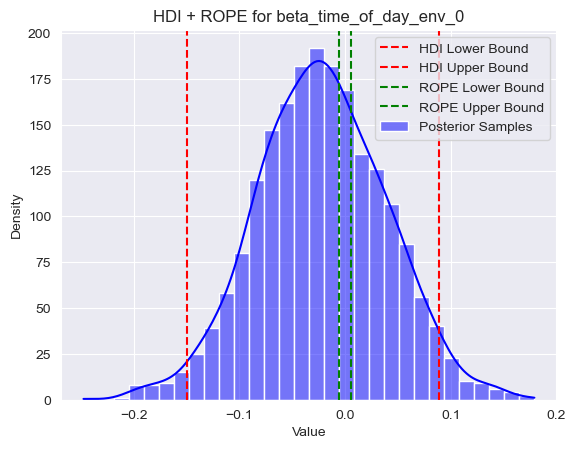

beta_time_of_day_env_1 HDI: [-0.1876, 0.0881]
beta_time_of_day_env_1 ROPE: [-0.0072, 0.0072]


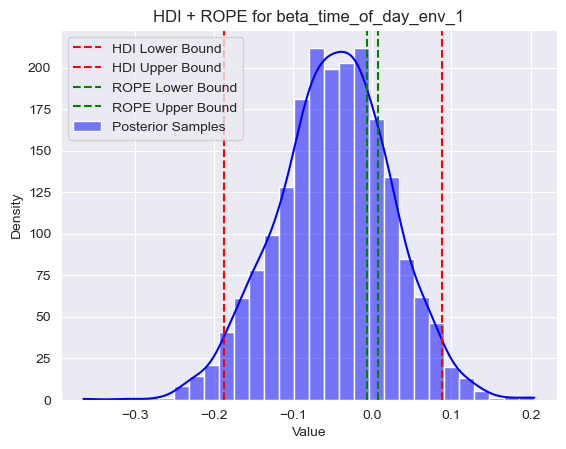

mu_time_of_day HDI: [-0.6174, 0.4940]
mu_time_of_day ROPE: [-0.2561, 0.2561]


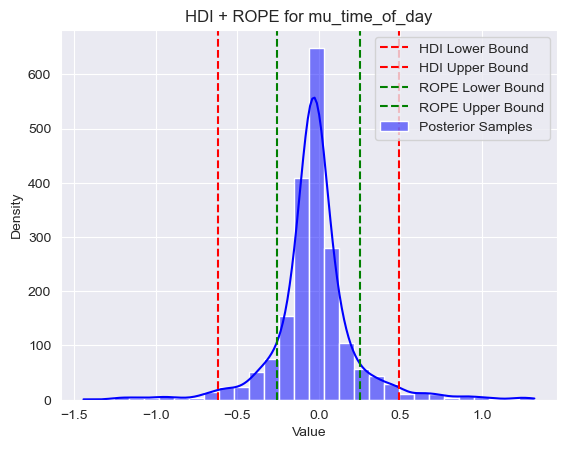

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9975
--------- Predictor 1 ---------
beta_day_of_week_env_0 HDI: [-0.0411, 0.0275]
beta_day_of_week_env_0 ROPE: [-0.0018, 0.0018]


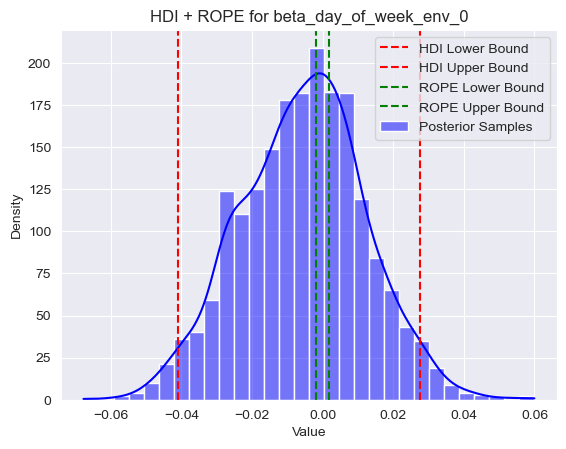

beta_day_of_week_env_1 HDI: [-0.0409, 0.0291]
beta_day_of_week_env_1 ROPE: [-0.0018, 0.0018]


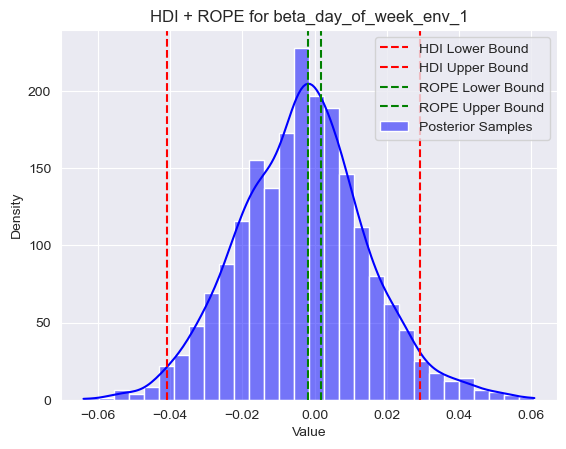

mu_day_of_week HDI: [-0.3130, 0.2807]
mu_day_of_week ROPE: [-0.1229, 0.1229]


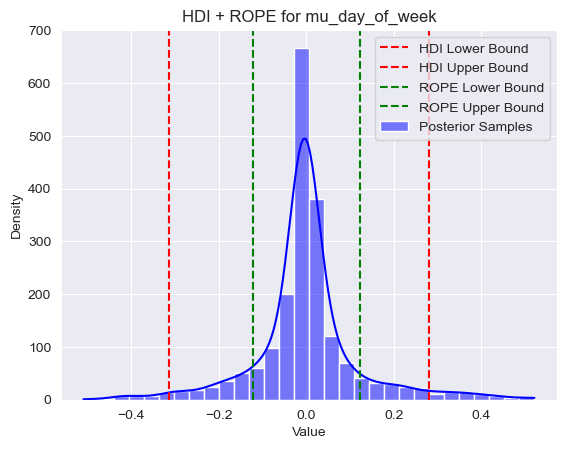

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9999
--------- Predictor 2 ---------
beta_traffic_state_env_0 HDI: [-0.2001, 0.1729]
beta_traffic_state_env_0 ROPE: [-0.0095, 0.0095]


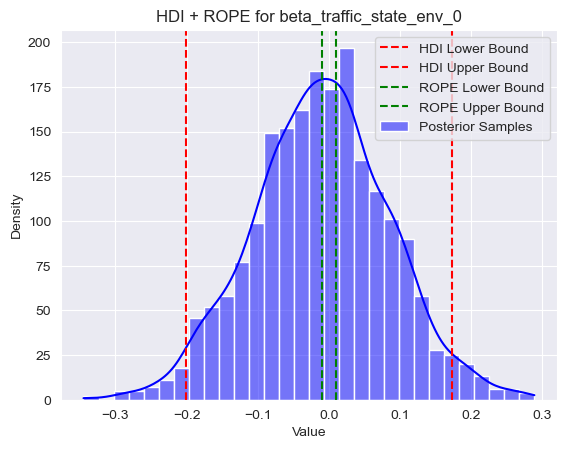

beta_traffic_state_env_1 HDI: [-0.1065, 0.1768]
beta_traffic_state_env_1 ROPE: [-0.0071, 0.0071]


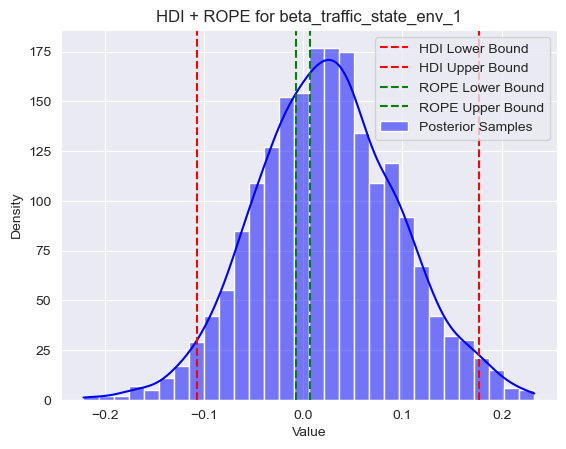

mu_traffic_state HDI: [-0.5778, 0.7312]
mu_traffic_state ROPE: [-0.2940, 0.2940]


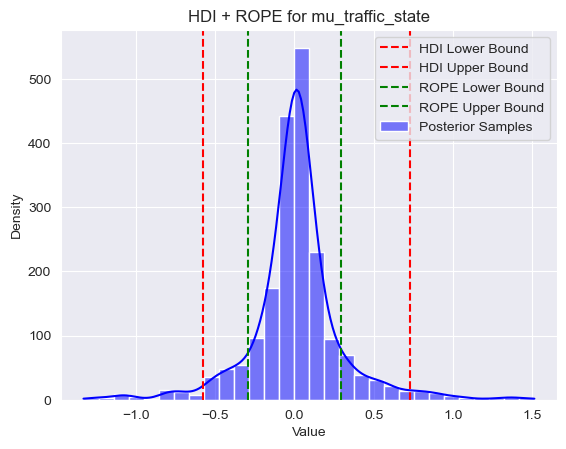

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9964
--------- Predictor 3 ---------
beta_boarding_passengers_env_0 HDI: [0.6324, 1.0169]
beta_boarding_passengers_env_0 ROPE: [-0.0100, 0.0100]


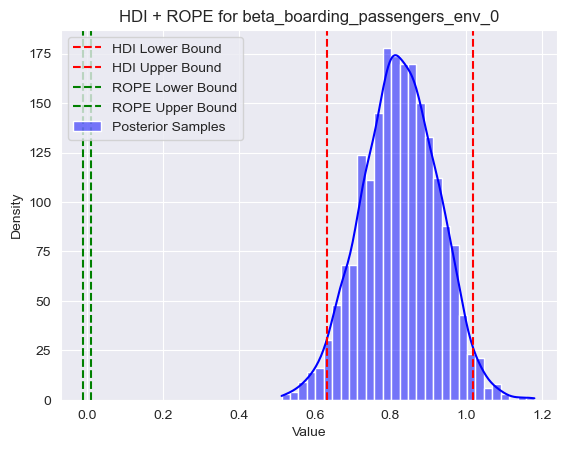

beta_boarding_passengers_env_1 HDI: [0.8459, 1.1063]
beta_boarding_passengers_env_1 ROPE: [-0.0067, 0.0067]


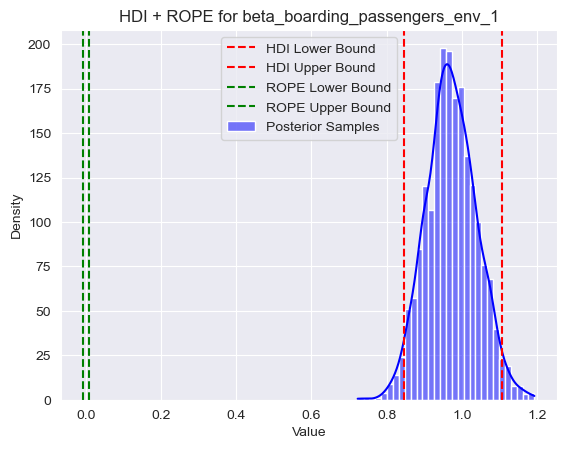

mu_boarding_passengers HDI: [-0.2301, 1.3363]
mu_boarding_passengers ROPE: [-0.3799, 0.3799]


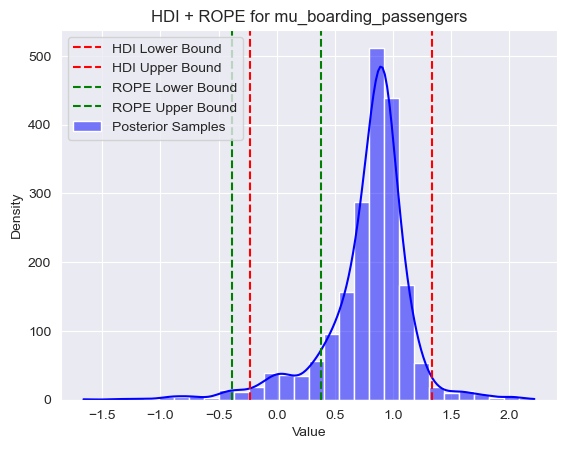

Local tests: ['Rejected', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.9621
--------- Predictor 4 ---------
beta_alighting_passengers_env_0 HDI: [0.2482, 0.5109]
beta_alighting_passengers_env_0 ROPE: [-0.0067, 0.0067]


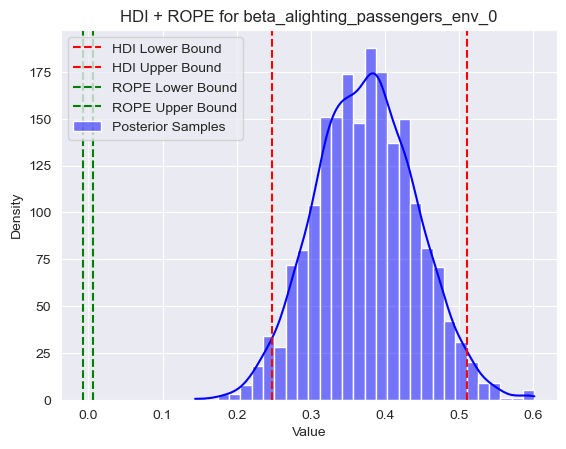

beta_alighting_passengers_env_1 HDI: [0.1664, 0.4170]
beta_alighting_passengers_env_1 ROPE: [-0.0064, 0.0064]


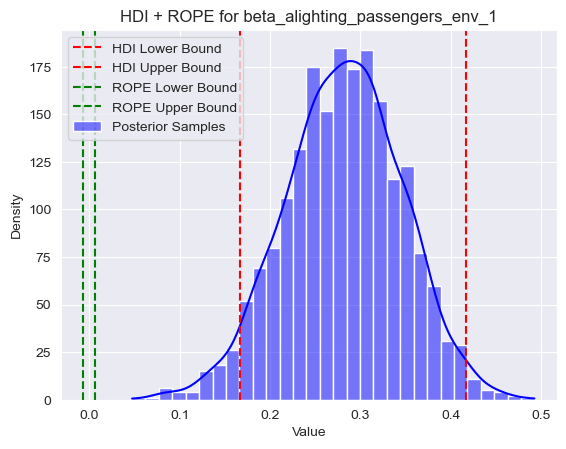

mu_alighting_passengers HDI: [-0.3634, 0.8765]
mu_alighting_passengers ROPE: [-0.2870, 0.2870]


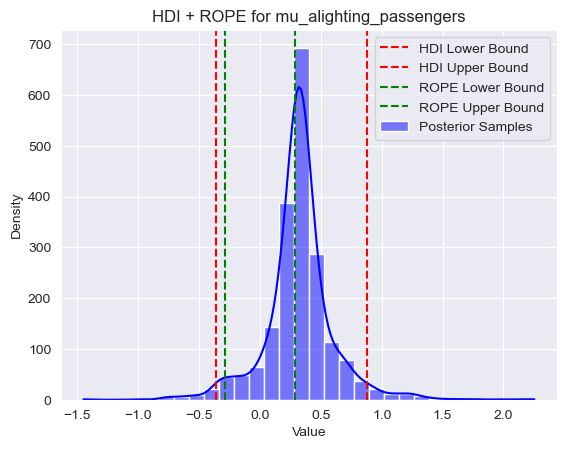

Local tests: ['Rejected', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.9737
CONCLUSION
Predictors with significant mu (mu_pass): []
Predictors with significant beta in all environments (beta_pass): [3, 4]
Predictors with high pooling factor (pool_pass): [0, 1, 2, 3, 4]


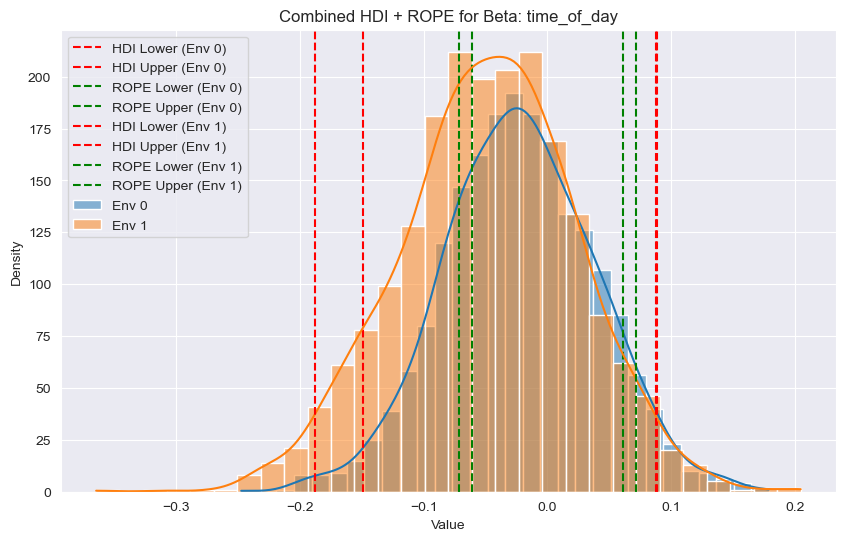

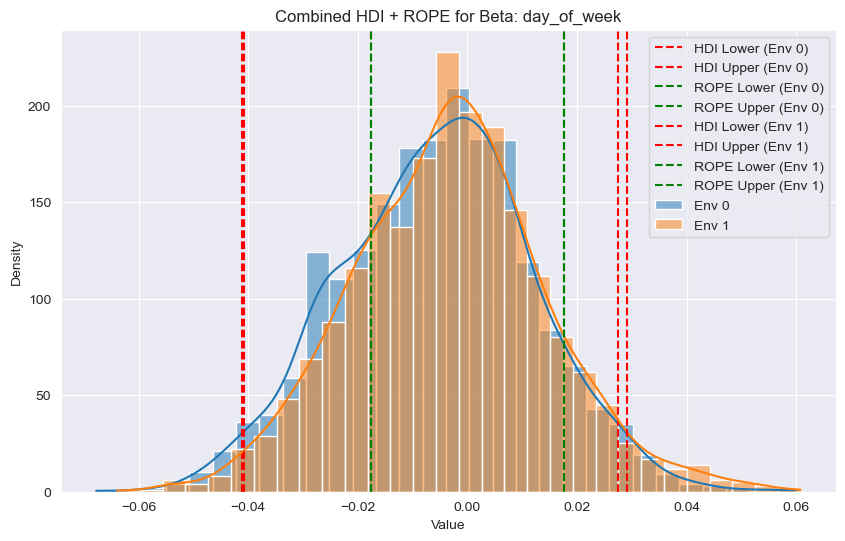

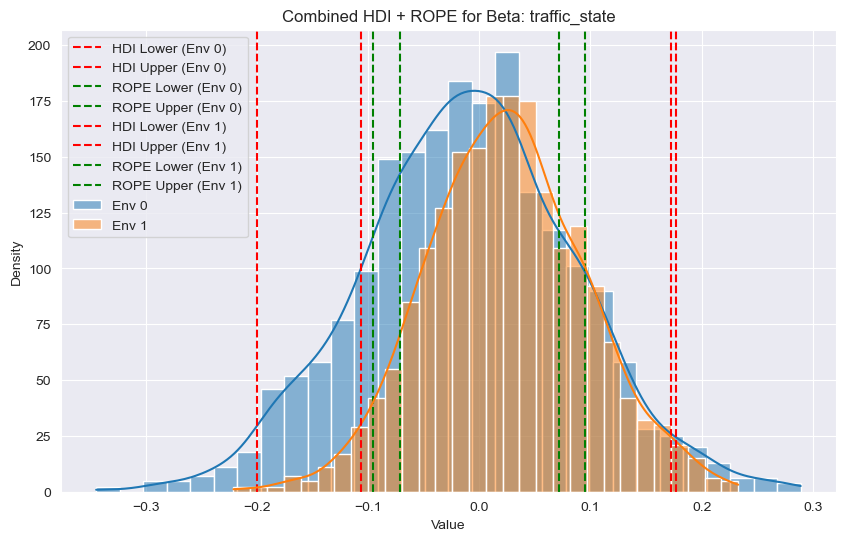

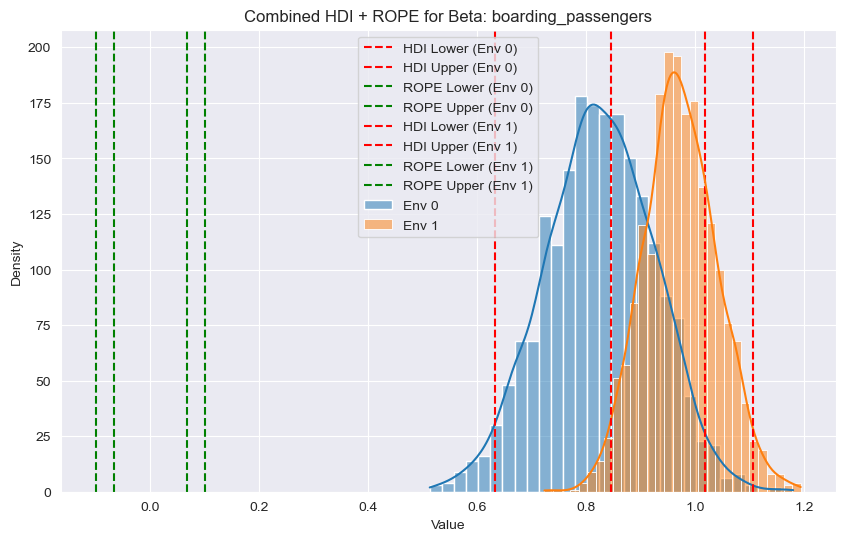

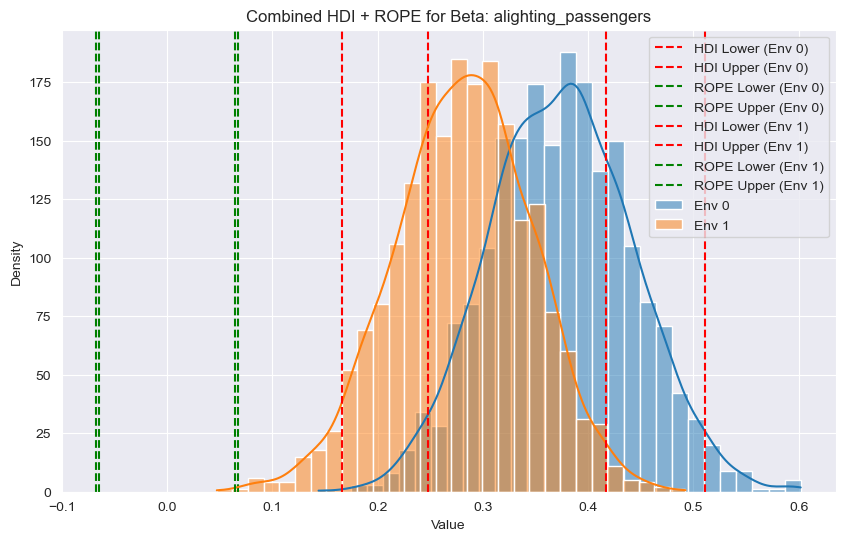

In [14]:
invariance_results = invariance_tests(
    posterior_samples,
    D=X_jax.shape[1],
    E=E,
    global_rope="tenth_sd",
    local_rope="tenth_sd",
    printing=True,
    X_cols=predictors
)